In [66]:
# Load in libraries
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import numpy as np
from torch.utils.data import DataLoader
from IPython.display import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
from sklearn.metrics import classification_report
%matplotlib inline

In [67]:
train = '/Users/jaxen1/Shared/C/Machine Learning/project2/Untitled/MachineLearningProject3/images/train'
razorback_transforms = transforms.Compose([
    transforms.Resize(128),              # resize shortest side to 128, keep aspect ratio
    transforms.CenterCrop([128, 128]),   # crop to square
    transforms.RandomHorizontalFlip(),
    #transforms.ToTensor()
])

dataset = ImageFolder(root=train, transform = razorback_transforms)
print('Number of images:', len(dataset))

Number of images: 60


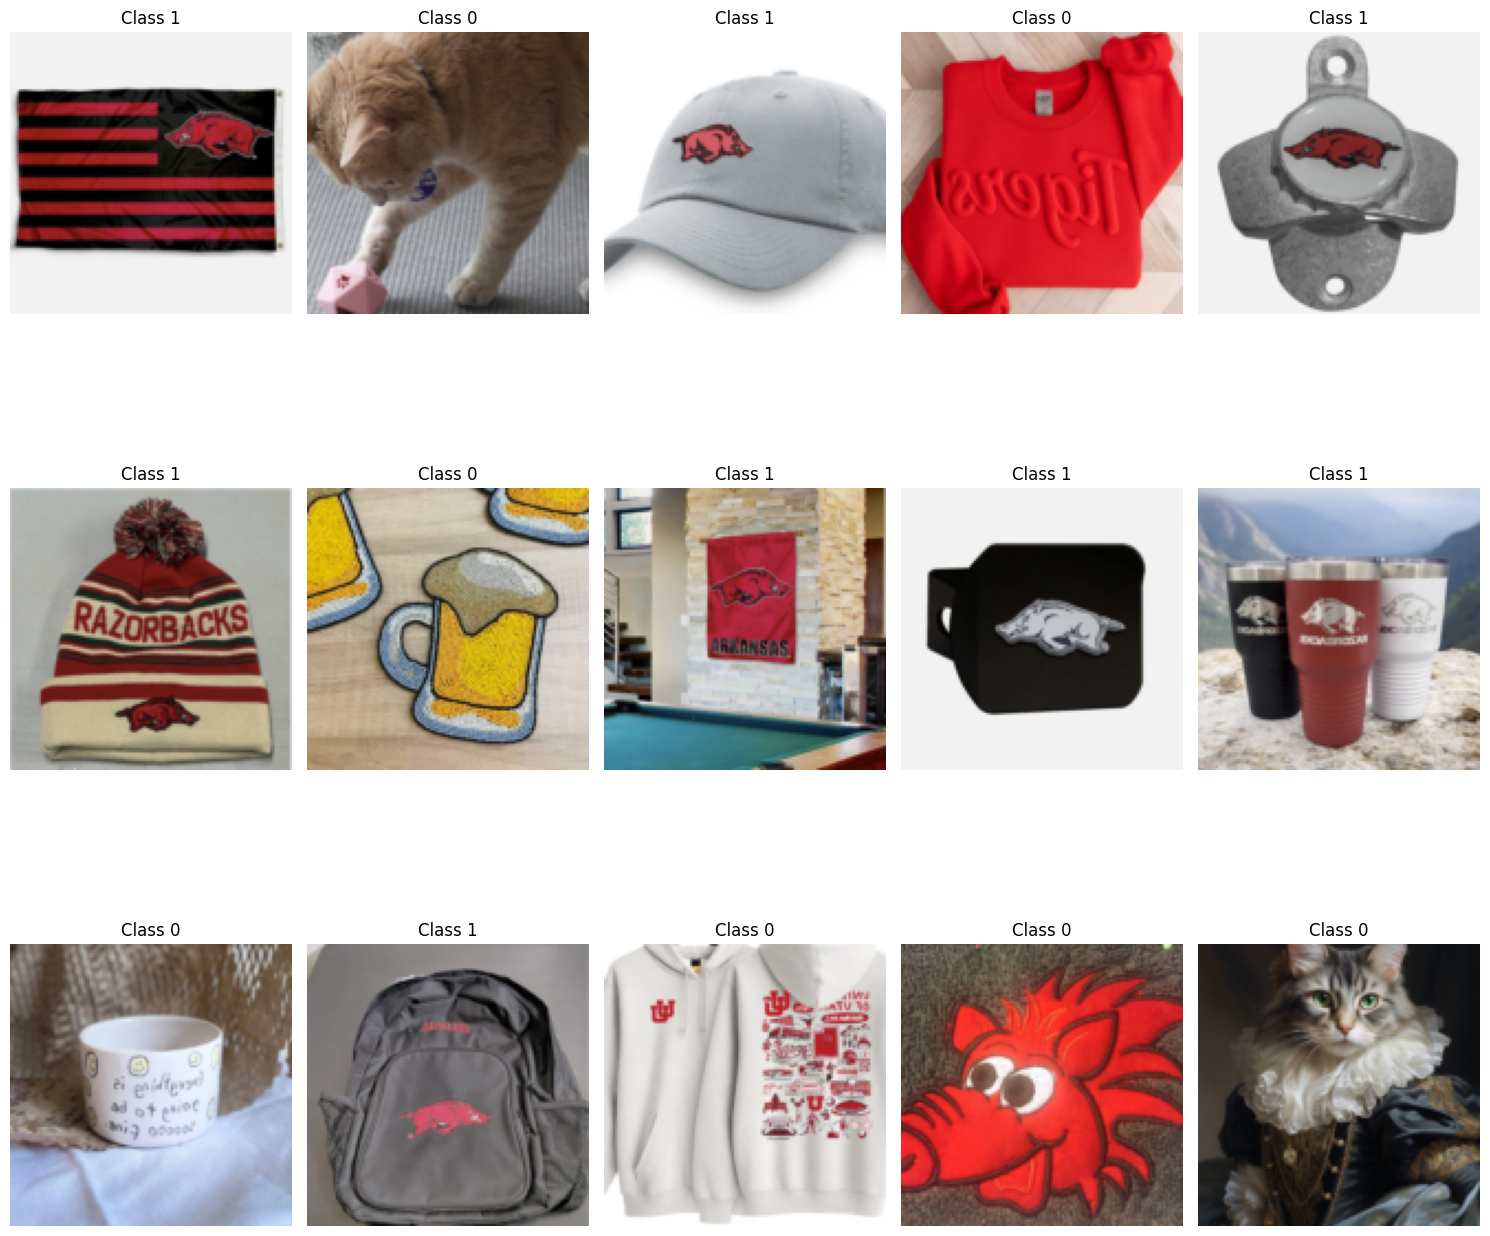

In [69]:
import random

# Fix randomness
torch.manual_seed(17)
random.seed(17)

# Generate shuffled indices
indices = list(range(len(dataset)))
random.shuffle(indices)

# Plot 15 images
fig = plt.figure(figsize=(15, 15))
for i, idx in enumerate(indices[:15]):   # take first 15 shuffled
    img, label = dataset[idx]
    ax = fig.add_subplot(3, 5, i + 1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"Class {label}")

plt.tight_layout()
plt.show()



In [70]:
transformsToTensor = transforms.Compose([
    transforms.Resize(128),              # resize shortest side to 128, keep aspect ratio
    transforms.CenterCrop([128, 128]),   # crop to square
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop([128, 128]),
    transforms.ToTensor()
])


dataset = ImageFolder(root=train, transform = transformsToTensor)
print('Train set:', len(dataset))

Train set: 60


In [71]:

# Create data loader
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
torch.manual_seed(17)



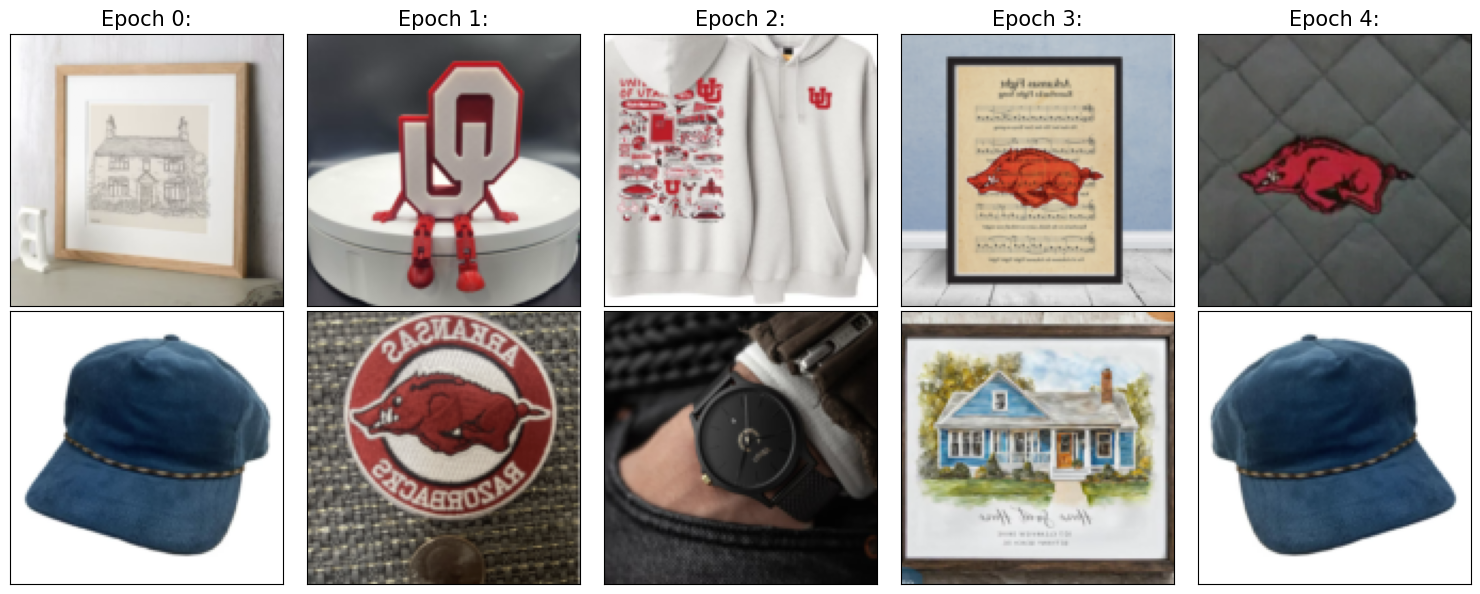

In [72]:
# Visalize how data is samplesd in different epochs
fig = plt.figure(figsize=(15, 6))

num_epochs = 5
for j in range(num_epochs):
    img_batch, label_batch = next(iter(train_loader))
    img = img_batch[0]
    ax = fig.add_subplot(2, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Epoch {j}:', size=15)
    ax.imshow(img.permute(1, 2, 0))

    img = img_batch[1]
    ax = fig.add_subplot(2, 5, j + 6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0))

plt.tight_layout()
plt.show()

In [73]:
# Create the training and test split
torch.manual_seed(21)
train_size = int(0.75 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply the test transforms to the test dataset
val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

In [74]:
# Create model architecture
model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout1', nn.Dropout(p=0.5))

model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout2', nn.Dropout(p=0.5))

model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))

model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('relu4', nn.ReLU())

In [75]:
# Flatten layer

x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 256, 8, 8])

In [76]:
# add average pool layer
model.add_module('pool4', nn.AvgPool2d(kernel_size=8))

# add flatten layer
model.add_module('flatten', nn.Flatten())

# add final dense layer
x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 256])

In [77]:

# add final dense layer
model.add_module('fc', nn.Linear(1024, 1))

# add sigmoid activation function
model.add_module('sigmoid', nn.Sigmoid())

In [78]:

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model = model.to(device)

In [79]:

# Define loss function
loss_fn = nn.BCELoss()

In [80]:
# Training function for model
def train(model, num_epochs, train_dl, valid_dl, optimizer):

    # make arrays to hold loss and accuracy values
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    # run over all epochs
    for epoch in range(num_epochs):

        # train the model on the data
        model.train()

        # Make loops over batches
        for x_batch, y_batch in train_dl:
            # send data to device
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # predict output
            pred = model(x_batch)[:, 0]

            # output loss
            loss = loss_fn(pred, y_batch.float())

            # backpropagate the  error
            loss.backward()

            # set up new weights
            optimizer.step()

            # set the gradients to zero
            optimizer.zero_grad()

            # update loss and accuracy values
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        # normalize loss and accuracy by dataset size
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        # validate the model
        model.eval()

        # disable gradient calculation
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')

    # return the loss and accuracy history arrays for variable plotting
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid


In [81]:
import copy
import random
# fix randomness for reproducibility
seed = 17
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# create three copies of the model for different batch sizes
model1 = copy.deepcopy(model)
model2 = copy.deepcopy(model) 
model3 = copy.deepcopy(model)

# train the three models with different batch sizes
histb8 = train(model1, num_epochs=30,
     train_dl=DataLoader(train_dataset, batch_size=8, shuffle=True),
     valid_dl=DataLoader(val_dataset, batch_size=8),
     optimizer=torch.optim.Adam(model1.parameters(), lr=0.001))  

histb16 = train(model2, num_epochs=30,
     train_dl=DataLoader(train_dataset, batch_size = 16, shuffle=True),
     valid_dl=DataLoader(val_dataset, batch_size=16),
     optimizer=torch.optim.Adam(model2.parameters(), lr=0.001))  # model3!

histb32 = train(model3, num_epochs=30,
     train_dl=DataLoader(train_dataset, batch_size=32, shuffle=True),
     valid_dl=DataLoader(val_dataset, batch_size=32),
     optimizer=torch.optim.Adam(model3.parameters(), lr=0.001))  # model5!

Epoch 1 accuracy: 0.4667 val_accuracy: 0.5000
Epoch 2 accuracy: 0.5111 val_accuracy: 0.5000
Epoch 3 accuracy: 0.5111 val_accuracy: 0.5000
Epoch 4 accuracy: 0.5111 val_accuracy: 0.5000
Epoch 5 accuracy: 0.5111 val_accuracy: 0.5000
Epoch 6 accuracy: 0.5111 val_accuracy: 0.5000
Epoch 7 accuracy: 0.5111 val_accuracy: 0.5000
Epoch 8 accuracy: 0.5111 val_accuracy: 0.5000
Epoch 9 accuracy: 0.5111 val_accuracy: 0.5000
Epoch 10 accuracy: 0.5111 val_accuracy: 0.5000
Epoch 11 accuracy: 0.5111 val_accuracy: 0.5000
Epoch 12 accuracy: 0.5111 val_accuracy: 0.5000
Epoch 13 accuracy: 0.5111 val_accuracy: 0.6667
Epoch 14 accuracy: 0.5333 val_accuracy: 0.6667
Epoch 15 accuracy: 0.5778 val_accuracy: 0.8333
Epoch 16 accuracy: 0.6889 val_accuracy: 0.8333
Epoch 17 accuracy: 0.6222 val_accuracy: 0.8333
Epoch 18 accuracy: 0.6000 val_accuracy: 0.8333
Epoch 19 accuracy: 0.5333 val_accuracy: 0.8333
Epoch 20 accuracy: 0.6222 val_accuracy: 0.8333
Epoch 21 accuracy: 0.6000 val_accuracy: 0.8333
Epoch 22 accuracy: 0.6

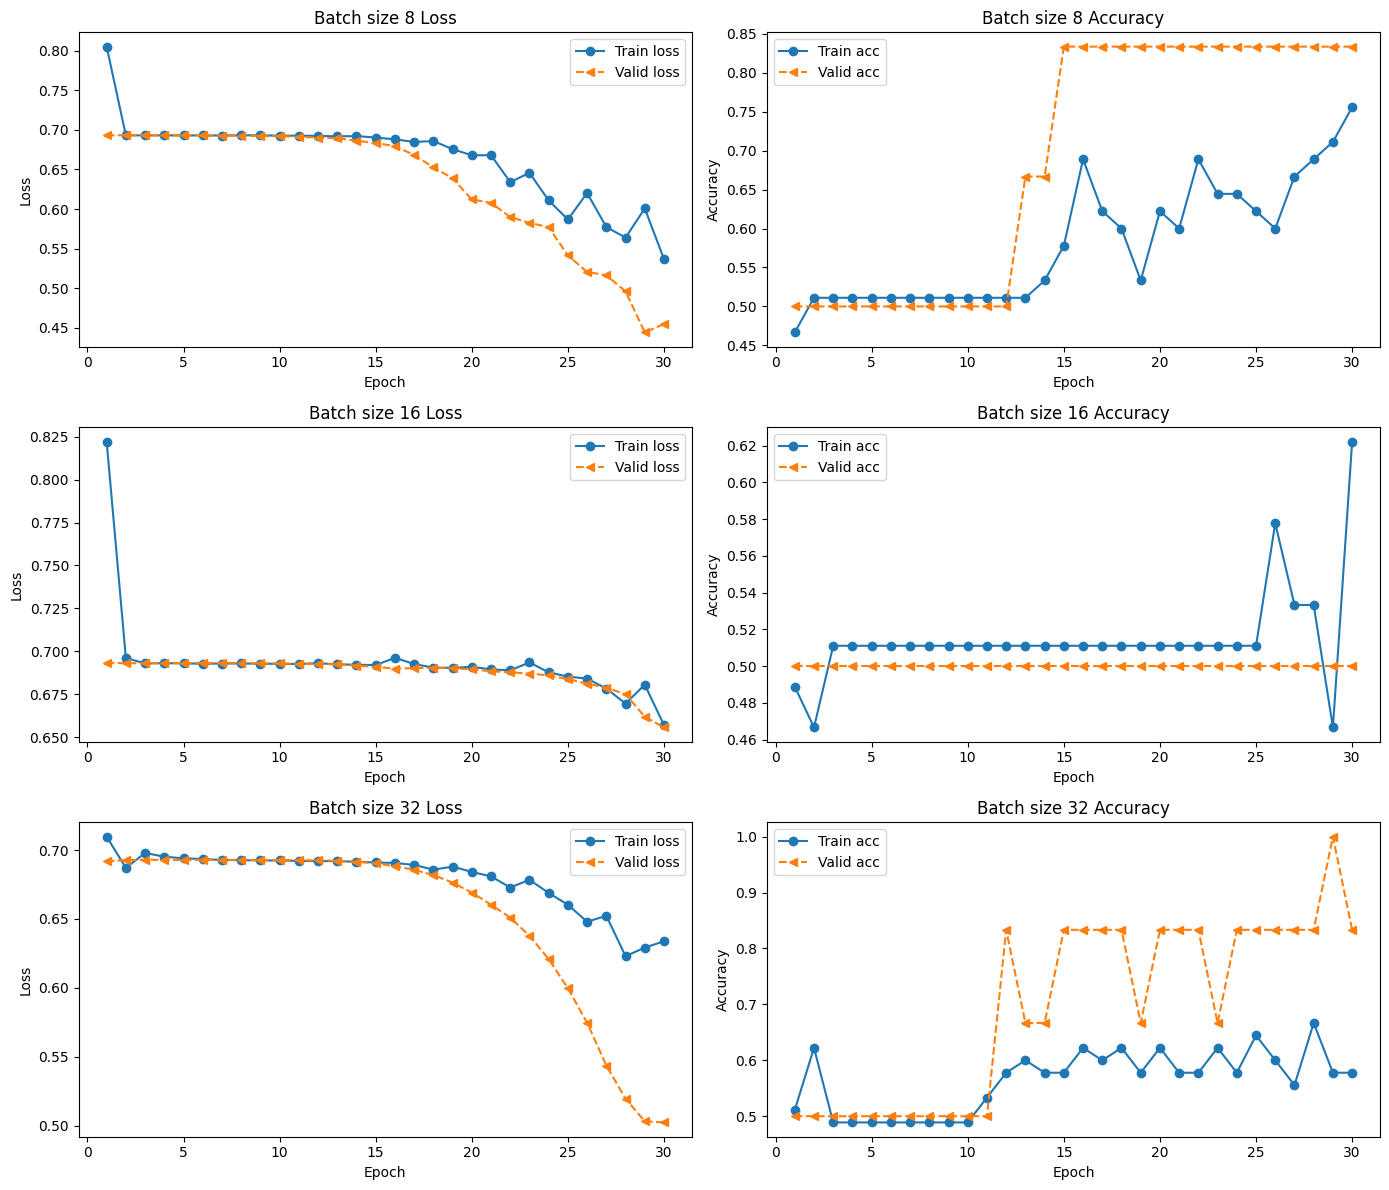

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# store all histories
all_runs = {
    "Batch size 8": histb8,
    "Batch size 16": histb16,
    "Batch size 32": histb32
}
# set up subplots
n_runs = len(all_runs)
fig, axes = plt.subplots(n_runs, 2, figsize=(14, 4 * n_runs))

# If only one run, make axes 2D array
if n_runs == 1:
    axes = np.array([axes])
# plot each run
for i, (name, hist) in enumerate(all_runs.items()):
    # Convert tensor accuracies to floats
    train_acc = [a.item() for a in hist[2]]
    valid_acc = [a.item() for a in hist[3]]
    
    x_arr = np.arange(len(hist[0])) + 1
    
    # Loss plot
    axes[i, 0].plot(x_arr, hist[0], '-o', label='Train loss')
    axes[i, 0].plot(x_arr, hist[1], '--<', label='Valid loss')
    axes[i, 0].set_title(f"{name} Loss")
    axes[i, 0].set_xlabel("Epoch")
    axes[i, 0].set_ylabel("Loss")
    axes[i, 0].legend()
    
    # Accuracy plot
    axes[i, 1].plot(x_arr, train_acc, '-o', label='Train acc')
    axes[i, 1].plot(x_arr, valid_acc, '--<', label='Valid acc')
    axes[i, 1].set_title(f"{name} Accuracy")
    axes[i, 1].set_xlabel("Epoch")
    axes[i, 1].set_ylabel("Accuracy")
    axes[i, 1].legend()

plt.tight_layout()
plt.show()


In [88]:
## for test

# Look at test accuracy
accuracy_test = 0
# Evaluate the best model (model2)
model2.eval()

# set up to collect true and predicted labels
y_true, y_pred = [], []
with torch.no_grad():
    for x_batch, y_batch in DataLoader(test_dataset, batch_size=4):
        x_batch = x_batch.to(device)
        y_batch = y_batch.cpu()
        pred = (model1(x_batch)[:,0].cpu() >= 0.5).int()
        y_true.extend(y_batch.numpy())
        y_pred.extend(pred.numpy())

accuracy_test /= len(DataLoader(test_dataset, batch_size=4).dataset)

print(classification_report(y_true, y_pred))

## for validation

# Look at validation accuracy
accuracy_test = 0
# Evaluate the best model (model2)
model.eval()

# set up to collect true and predicted labels
y_true, y_pred = [], []
with torch.no_grad():
    for x_batch, y_batch in DataLoader(val_dataset, batch_size=4):
        x_batch = x_batch.to(device)
        y_batch = y_batch.cpu()
        pred = (model1(x_batch)[:,0].cpu() >= 0.5).int()
        y_true.extend(y_batch.numpy())
        y_pred.extend(pred.numpy())

accuracy_test /= len(DataLoader(val_dataset, batch_size=4).dataset)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.50      0.50      0.50         4

    accuracy                           0.56         9
   macro avg       0.55      0.55      0.55         9
weighted avg       0.56      0.56      0.56         9

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6



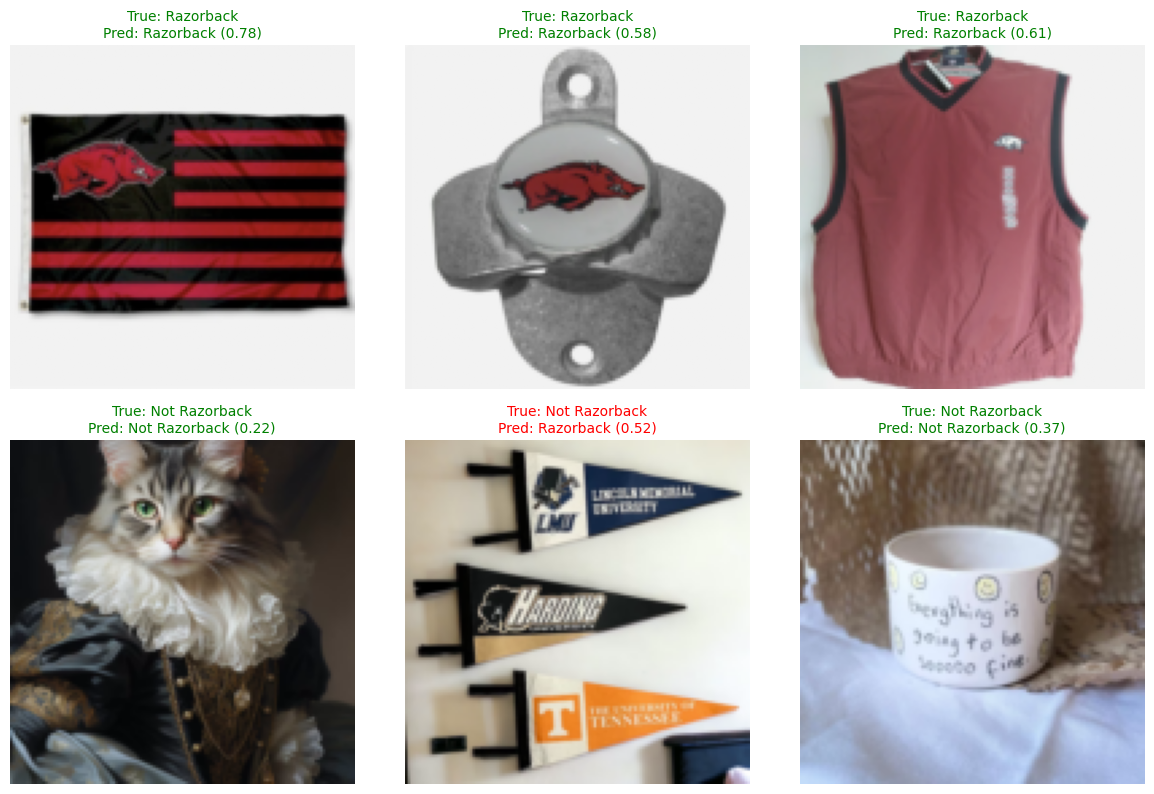

In [89]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Move model to eval mode
model.eval()

# Get all test predictions and labels
all_preds = []
all_probs = []
all_labels = []
all_images = []

with torch.no_grad():
    for x_batch, y_batch in DataLoader(val_dataset, batch_size=4):
        x_batch = x_batch.to(device)
        y_batch_cpu = y_batch.cpu()
        probs = model1(x_batch)[:, 0].cpu()  
        preds = (probs >= 0.5).int()       

        all_preds.extend(preds.numpy())
        all_probs.extend(probs.numpy())
        all_labels.extend(y_batch_cpu.numpy())
        all_images.extend(x_batch.cpu())    
# Convert lists to arrays/tensors
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)
all_images = torch.stack(all_images)

# --- Visualize the first 16 images with predictions ---
num_images = min(16, len(all_images))
plt.figure(figsize=(12, 12))

for i in range(num_images):
    plt.subplot(3, 3, i+1)
    img = all_images[i].permute(1, 2, 0) 
    plt.imshow(img)
    # Set title with true label, predicted label, and probability
    true_label = "Razorback" if all_labels[i] == 1 else "Not Razorback"
    pred_label = "Razorback" if all_preds[i] == 1 else "Not Razorback"
    prob = all_probs[i]
    # Color the title based on correctness
    color = "green" if all_labels[i] == all_preds[i] else "red"  # correct in green, wrong in red
    plt.title(f"True: {true_label}\nPred: {pred_label} ({prob:.2f})", color=color, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [85]:
import os

# create models directory if it doesn't exist
if not os.path.exists('models'):
    os.mkdir('models')

path = 'models/razorback-cnn.ph'

# save the model
torch.save(model2, path)

In [86]:
# load the model
loaded_full_model = torch.load(path, weights_only=False)

# set to eval mode
loaded_full_model.eval()

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=1024, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

# Reflection:
## How did you create your dataset and determine split of official logo versus not official logo?
We began by first searching for the official Razorback logo on Etsy. Our searches were "Arkansas Razorbacks" and "Razorbacks". We chose mostly the ones with the official colors but chose some that was the original logo but had some white in it. We found 25 of these images first. We then went through the same search and selected 7 images that were alternate hog logos. We wanted to try to add some variation so that the model would be better at picking up on the actual razorback logo. We then filled the rest of the images with various searches like "dogs", "cats", and just random items that appeared on the home page. We got to 25 as well for these.

We then played around with the number of images sampled from each yes/no category. We tried more no's and more yes's but found that on average it performed better with an equal split. We then tried to improve the model further by adding 5 more images for both the yes and no category to finally land at 30 images for each for our final model. Finally, we used the counter collection package to randomly select images for the train, test, and validation splits for a optimal dispertion of images.

## Why did you choose the specific architecture for the final model?
We systematically tested different learning rates and batch sizes to find optimal hyperparameters for our model. We chose the Adam optimizer because it adaptively adjusts learning rates during training, leading to faster and more stable convergence than SGD for our small image dataset. Through experimentation, we selected a learning rate of 0.001 after finding that 0.01 was too aggressive and caused training instability, while 0.0001 converged too slowly. We trained for 30 epochs, which was the point where validation accuracy stabilized and the train-validation gap became acceptable. Finally, we used a batch size of 8 because it provides more frequent weight updates per epoch, which is beneficial for our small dataset of 45 training samples, allowing the model to adjust more often and explore the loss landscape more thoroughly.
## How did you monitor and mitigate overfitting?
To monitor overfitting in the model we take the precautions of splitting our data into a train/test and validation sets. By using the counter package, we put 45 images in the training set, 9 images in the test set, and 6 for the validation set. This package allowed us to evenly distribute yes/no images as equal as possible into each subsection. We then logged the training loss/accuracy and the validation loss/accuracy over every epoch iteration to monitor the performance. This allows us to see when the accuracy is plateauing or decreasing, and the loss is increased. When we see these benchmarks, we know that the model is beginning to overfit. Most importantly, we regularized and preprocessed our data. This involved resizing to a standardized dimension and augmenting the images. By cropping, flipping, and rotating the images randomly it allows the model to generalize better on new images coming into the model. With the regularization techniques in the model, it mad ethe model better at not overfitting. By using dropout in the final layers, we can randomly drop neurons to make sure the model is not completely relying on a single learning style and uses various forms and combinations of neurons. We also made sure to keep the model as simple as possible to keep the number of parameters smaller and overly complicating things.

## What future efforts do you recommend to improve model performance?
For a project like this, the more images you have the better. The first thing we would do would be to add more images to the library of images we are training from. We would also employ more variation to the images and ideally with a larger selection of images we can really nail down on the model to find the actual razorback and be able to differentiate from the official logo and the front facing hog or other unofficial logos.

We could also try testing this model with already pre made and pre trained CNN models to compare results. We can also always do more parameter tuning and testing different layer combinations to optimize the process.

Finally we can always dive deeper into the evaluation of the model to further understand why its predictions were wrong. We could work to better understand if the model is predicting yes/no on a higher scale and understanding the reasons for that.

